In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pylab

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [12]:
# calculate most recent date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

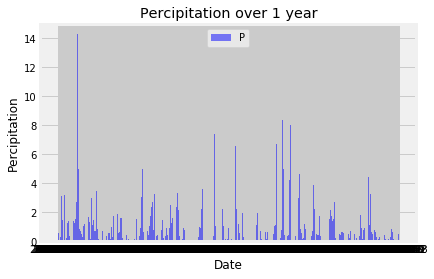

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores
year_percp = session.query(func.sum(Measurement.prcp), Measurement.date).\
    filter(Measurement.date > '2016-08-23').group_by(Measurement.date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
percp_df = pd.DataFrame(year_percp, columns=['Percp', 'Date'])
percp_df.set_index('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
x = percp_df.index
y = percp_df.Percp
plt.bar(x, y, alpha=.5, color='Blue', align='center')
plt.title("Percipitation over 1 year")
plt.xlabel("Date")
plt.ylabel("Percipitation")
pylab.legend("Percp", loc="upper center")

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
percp_df.describe()

,Percp
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [15]:
# How many stations are available in this dataset?
session.query(Measurement.station).group_by('station').count()

9

In [16]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by('station').order_by(Measurement.station.desc()).all()

[('USC00519523', 2669),
 ('USC00519397', 2724),
 ('USC00519281', 2772),
 ('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00513117', 2709),
 ('USC00511918', 1979)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
low_temp = session.query(func.min(Measurement.tobs)).all()
print(low_temp)

high_temp = session.query(func.max(Measurement.tobs)).all()
print(high_temp)

avg_temp = session.query(func.avg(Measurement.tobs)).all()
print(avg_temp)

[(53.0,)]
[(87.0,)]
[(73.09795396419437,)]


Text(0,0.5,'Frequency')

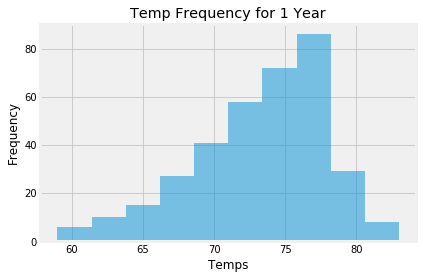

In [18]:
# Choose the station with the highest number of temperature observations.
'USC00519281, 2772'
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
target = 'USC00519281'
result = session.query(Measurement.tobs).filter(Measurement.station == target).\
        filter(Measurement.date >= '2016-08-23').all()

top_df = pd.DataFrame(result, columns=['Temp'])
x = top_df['Temp']

plt.hist(x, alpha=.5)

plt.title("Temp Frequency for 1 Year")
plt.xlabel("Temps")
plt.ylabel("Frequency")

In [19]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


Text(0.5,1,'Trip Avg Temp')

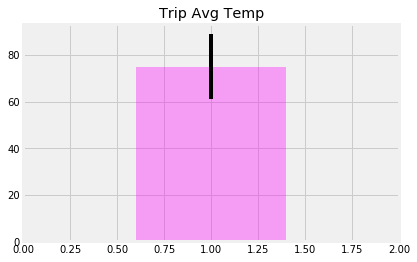

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


x = calc_temps('2011-02-28', '2011-03-05')
x1 = x[0][0]
x2 = x[0][-1]
y = x[0][1]
x= [x1, x2, y]
peak = x2 - x1

plt.bar(1, x2, yerr=peak, color = 'magenta', alpha=.35)
axes = plt.gca()
axes.set_xlim(0 , 2)
plt.title('Trip Avg Temp')

In [22]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_temps(start_date, end_date):
    return session.query(Measurement.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation).\
    group_by('station').order_by(Measurement.prcp.desc()).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2011-02-28', '2011-03-05'))

[('USC00516128', 'HONOLULU OBSERVATORY 702.2, HI US', 13.609999999999996, 21.3152, -157.9992, 0.9), ('USC00516128', 'KANEOHE 838.1, HI US', 13.609999999999996, 21.4234, -157.8015, 14.6), ('USC00516128', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 13.609999999999996, 21.5213, -157.8374, 7.0), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 13.609999999999996, 21.3331, -157.8025, 152.4), ('USC00516128', 'PEARL CITY, HI US', 13.609999999999996, 21.3934, -157.9751, 11.9), ('USC00516128', 'UPPER WAHIAWA 874.3, HI US', 13.609999999999996, 21.4992, -158.0111, 306.6), ('USC00516128', 'WAIHEE 837.5, HI US', 13.609999999999996, 21.45167, -157.84888999999998, 32.9), ('USC00516128', 'WAIKIKI 717.2, HI US', 13.609999999999996, 21.2716, -157.8168, 3.0), ('USC00516128', 'WAIMANALO EXPERIMENTAL FARM, HI US', 13.609999999999996, 21.33556, -157.71139, 19.5)]


## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
